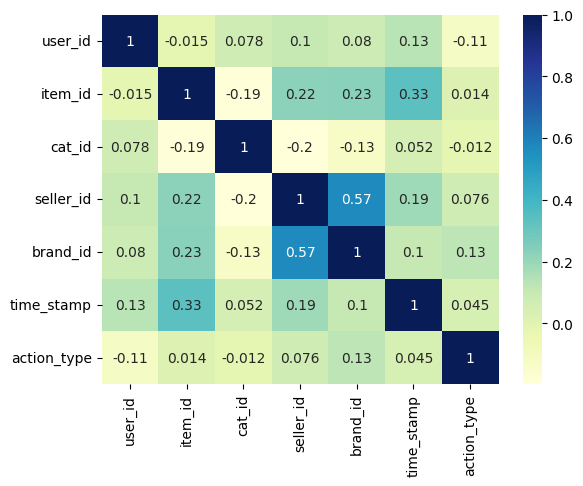

In [21]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()


In [22]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.5 MB/s eta 0:00:00


In [23]:
import pandas as pd

# Load the user behavior logs data
user_behavior_logs = pd.read_csv("/content/drive/MyDrive/PR Project/user_log_format1.csv")

# Load the user profile data
user_profile = pd.read_csv("/content/drive/MyDrive/PR Project/user_info_format1.csv")

# Load the training data
training_data = pd.read_csv("/content/drive/MyDrive/PR Project/train_format1.csv")

# Merge user behavior logs and user profile data on 'user_id'
merged_data = pd.merge(user_behavior_logs, user_profile, on='user_id', how='left')

# Extract features from the merged data

# User demographics features
age_range_mapping = {0: 'unknown', 1: '<18', 2: '[18,24]', 3: '[25,29]', 4: '[30,34]', 5: '[35,39]', 6: '[40,49]', 7: '>= 50', 8: '>= 50'}
merged_data['age_range'] = merged_data['age_range'].map(age_range_mapping)
merged_data = pd.get_dummies(merged_data, columns=['age_range', 'gender'], prefix=['age', 'gender'])

# User behavior features
user_behavior_features = merged_data.groupby('user_id').agg({
    'action_type': ['count', 'sum'],
    'item_id': ['nunique'],
    # Replace 'seller_id' with the correct column name representing the merchant or seller ID
    'seller_id': ['nunique'],
    'cat_id': ['nunique'],
    'brand_id': ['nunique']
})

user_behavior_features.columns = ['total_actions', 'total_purchases', 'unique_items', 'unique_merchants', 'unique_categories', 'unique_brands']
user_behavior_features.reset_index(inplace=True)

# Merge user behavior features with training data on 'user_id' and the correct merchant ID column
# Replace 'seller_id' with the correct column name representing the merchant or seller ID in training_data
final_data = pd.merge(training_data, user_behavior_features, on=['user_id'], how='left')

# Check the final_data
print(final_data.head())

# Save the final_data to a new CSV file
final_data.to_csv("final_data.csv", index=False)


   user_id  seller_id  label  total_actions  total_purchases  unique_items  \
0    34176       3906      0            NaN              NaN           NaN   
1    34176        121      0            NaN              NaN           NaN   
2    34176       4356      1            NaN              NaN           NaN   
3    34176       2217      0            NaN              NaN           NaN   
4   230784       4818      0            NaN              NaN           NaN   

   unique_merchants  unique_categories  unique_brands  
0               NaN                NaN            NaN  
1               NaN                NaN            NaN  
2               NaN                NaN            NaN  
3               NaN                NaN            NaN  
4               NaN                NaN            NaN  


In [24]:
training_data = pd.read_csv("/content/drive/MyDrive/PR Project/train_format1.csv")
print(training_data.head())

   user_id  seller_id  label
0    34176       3906      0
1    34176        121      0
2    34176       4356      1
3    34176       2217      0
4   230784       4818      0


In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('final_data.csv')

# Split the dataset into features (X) and target variable (y)
X = df.drop('label', axis=1)
y = df['label']

# Handle missing values by filling them with the mean of each column
imputer = SimpleImputer()
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print("Model accuracy:", accuracy)


Model accuracy: 0.9193069212044545


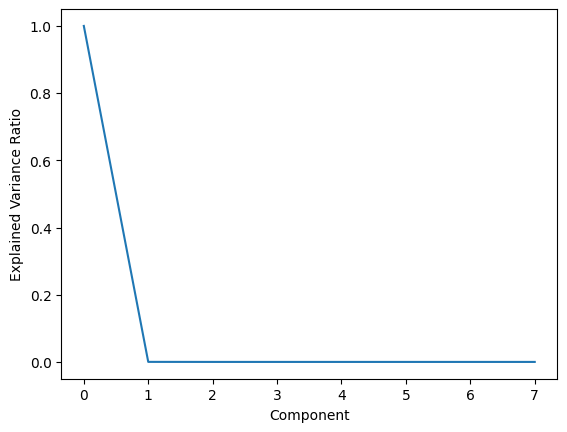

In [26]:
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA model to the dataset
pca.fit(X)

# Compute the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio using a line chart
sns.lineplot(x=range(len(explained_variance_ratio)), y=explained_variance_ratio)
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.show()
